## Texas Hospital Discharge - EDA

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy import stats
import yaml, time, sys, os, glob

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

DATASET = "Texas_Inpatient_Discharge"
SPLIT_TRAINING = True
DEBUG = False
SEED = 42

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

## Functions

In [2]:
def clean_cat (feature, mapping):
  if df[feature].dtype!="category":
    tmp = df[feature].map(mapping)
    assert tmp.isna().sum()==0, f"Found {tmp.isna().sum()} missing values"
    df[feature] = pd.Categorical(tmp)

## Dataset

In [3]:
df = pd.read_pickle(f"{ROOT}/data/df_train_sample_00_of_1.pkl")
print(df.shape)
df.head()

(999698, 195)


,RECORD_ID,DISCHARGE,THCIC_ID,PROVIDER_NAME,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,SPEC_UNIT_1,SPEC_UNIT_2,SPEC_UNIT_3,SPEC_UNIT_4,SPEC_UNIT_5,PAT_STATE,PAT_ZIP,PAT_COUNTRY,COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,SECONDARY_PAYMENT_SRC,TYPE_OF_BILL,TOTAL_CHARGES,TOTAL_NON_COV_CHARGES,TOTAL_CHARGES_ACCOMM,TOTAL_NON_COV_CHARGES_ACCOMM,TOTAL_CHARGES_ANCIL,TOTAL_NON_COV_CHARGES_ANCIL,POA_PROVIDER_INDICATOR,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE,OTH_DIAG_CODE_1,POA_OTH_DIAG_CODE_1,OTH_DIAG_CODE_2,POA_OTH_DIAG_CODE_2,OTH_DIAG_CODE_3,POA_OTH_DIAG_CODE_3,OTH_DIAG_CODE_4,POA_OTH_DIAG_CODE_4,OTH_DIAG_CODE_5,POA_OTH_DIAG_CODE_5,OTH_DIAG_CODE_6,POA_OTH_DIAG_CODE_6,OTH_DIAG_CODE_7,POA_OTH_DIAG_CODE_7,OTH_DIAG_CODE_8,POA_OTH_DIAG_CODE_8,OTH_DIAG_CODE_9,POA_OTH_DIAG_CODE_9,OTH_DIAG_CODE_10,POA_OTH_DIAG_CODE_10,OTH_DIAG_CODE_11,POA_OTH_DIAG_CODE_11,OTH_DIAG_CODE_12,POA_OTH_DIAG_CODE_12,OTH_DIAG_CODE_13,POA_OTH_DIAG_CODE_13,OTH_DIAG_CODE_14,POA_OTH_DIAG_CODE_14,OTH_DIAG_CODE_15,POA_OTH_DIAG_CODE_15,OTH_DIAG_CODE_16,POA_OTH_DIAG_CODE_16,OTH_DIAG_CODE_17,POA_OTH_DIAG_CODE_17,OTH_DIAG_CODE_18,POA_OTH_DIAG_CODE_18,OTH_DIAG_CODE_19,POA_OTH_DIAG_CODE_19,OTH_DIAG_CODE_20,POA_OTH_DIAG_CODE_20,OTH_DIAG_CODE_21,POA_OTH_DIAG_CODE_21,OTH_DIAG_CODE_22,POA_OTH_DIAG_CODE_22,OTH_DIAG_CODE_23,POA_OTH_DIAG_CODE_23,OTH_DIAG_CODE_24,POA_OTH_DIAG_CODE_24,E_CODE_1,POA_E_CODE_1,E_CODE_2,POA_E_CODE_2,E_CODE_3,POA_E_CODE_3,E_CODE_4,POA_E_CODE_4,E_CODE_5,POA_E_CODE_5,E_CODE_6,POA_E_CODE_6,E_CODE_7,POA_E_CODE_7,E_CODE_8,POA_E_CODE_8,E_CODE_9,POA_E_CODE_9,E_CODE_10,POA_E_CODE_10,PRINC_SURG_PROC_CODE,PRINC_SURG_PROC_DAY,PRINC_ICD9_CODE,OTH_SURG_PROC_CODE_1,OTH_SURG_PROC_DAY_1,OTH_ICD9_CODE_1,OTH_SURG_PROC_CODE_2,OTH_SURG_PROC_DAY_2,OTH_ICD9_CODE_2,OTH_SURG_PROC_CODE_3,OTH_SURG_PROC_DAY_3,OTH_ICD9_CODE_3,OTH_SURG_PROC_CODE_4,OTH_SURG_PROC_DAY_4,OTH_ICD9_CODE_4,OTH_SURG_PROC_CODE_5,OTH_SURG_PROC_DAY_5,OTH_ICD9_CODE_5,OTH_SURG_PROC_CODE_6,OTH_SURG_PROC_DAY_6,OTH_ICD9_CODE_6,OTH_SURG_PROC_CODE_7,OTH_SURG_PROC_DAY_7,OTH_ICD9_CODE_7,OTH_SURG_PROC_CODE_8,OTH_SURG_PROC_DAY_8,OTH_ICD9_CODE_8,OTH_SURG_PROC_CODE_9,OTH_SURG_PROC_DAY_9,OTH_ICD9_CODE_9,OTH_SURG_PROC_CODE_10,OTH_SURG_PROC_DAY_10,OTH_ICD9_CODE_10,OTH_SURG_PROC_CODE_11,OTH_SURG_PROC_DAY_11,OTH_ICD9_CODE_11,OTH_SURG_PROC_CODE_12,OTH_SURG_PROC_DAY_12,OTH_ICD9_CODE_12,OTH_SURG_PROC_CODE_13,OTH_SURG_PROC_DAY_13,OTH_ICD9_CODE_13,OTH_SURG_PROC_CODE_14,OTH_SURG_PROC_DAY_14,OTH_ICD9_CODE_14,OTH_SURG_PROC_CODE_15,OTH_SURG_PROC_DAY_15,OTH_ICD9_CODE_15,OTH_SURG_PROC_CODE_16,OTH_SURG_PROC_DAY_16,OTH_ICD9_CODE_16,OTH_SURG_PROC_CODE_17,OTH_SURG_PROC_DAY_17,OTH_ICD9_CODE_17,OTH_SURG_PROC_CODE_18,OTH_SURG_PROC_DAY_18,OTH_ICD9_CODE_18,OTH_SURG_PROC_CODE_19,OTH_SURG_PROC_DAY_19,OTH_ICD9_CODE_19,OTH_SURG_PROC_CODE_20,OTH_SURG_PROC_DAY_20,OTH_ICD9_CODE_20,OTH_SURG_PROC_CODE_21,OTH_SURG_PROC_DAY_21,OTH_ICD9_CODE_21,OTH_SURG_PROC_CODE_22,OTH_SURG_PROC_DAY_22,OTH_ICD9_CODE_22,OTH_SURG_PROC_CODE_23,OTH_SURG_PROC_DAY_23,OTH_ICD9_CODE_23,OTH_SURG_PROC_CODE_24,OTH_SURG_PROC_DAY_24,OTH_ICD9_CODE_24,MS_MDC,MS_DRG,MS_GROUPER_VERSION_NBR,MS_GROUPER_ERROR_CODE,APR_MDC,APR_DRG,RISK_MORTALITY,ILLNESS_SEVERITY,APR_GROUPER_VERSION_NBR,APR_GROUPER_ERROR_CODE,ATTENDING_PHYSICIAN_UNIF_ID,OPERATING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,CERT_STATUS,FILLER_SPACE,TARGET
884115,320136748870,2013Q3,838400,Memorial Hermann Rehab Hospital Katy,3,4,R,NaN,NaN,NaN,NaN,TX,77095,US,201,06,07,F,4,2,2,1,20,MA,MB,111,1671.00,0.00,1145.00,0.00,526.00,0.00,X,V5789,V5789,NaN,1919,Y,5119,Y,V8543,NaN,78459,Y,27801,Y,7812,Y,5180,Y,34590,Y,4019,Y,7993,Y,2724,Y,72887,Y,36250,Y,78093,Y,36901,Y,V5878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## EDA

In [4]:
target = "TARGET"
cat_features = ["TYPE_OF_ADMISSION","SOURCE_OF_ADMISSION","PAT_STATE", "RACE"]
num_features = []

### Target

* Slightly imbalanced (especially for 'long')
  * Stratify when split on train-test or CV

In [5]:
df.TARGET.value_counts(dropna=False, normalize=True)

short     0.414277
medium    0.381552
long      0.204171
Name: TARGET, dtype: float64

### 'RECORD_ID' - ignore

### 'DISCHARGE' - NKOA (NOT KNOWN ON ADMISSION)

### 'THCIC_ID' 
* Too many levels - need to merge rare before use

In [6]:
df.THCIC_ID.nunique()

566

### 'PROVIDER_NAME'

* Should be one-to-one with 'TCIC_ID' - so need only one
* Will decide (if) merging with faculty

In [7]:
df.PROVIDER_NAME.nunique()

561

### 'TYPE_OF_ADMISSION'

In [8]:
df.TYPE_OF_ADMISSION.value_counts(dropna=False)

1      431565
3      260916
2      171913
4      126449
5        4606
9        4225
`          17
NaN         7
Name: TYPE_OF_ADMISSION, dtype: int64

In [9]:
mapping = {
    "1" : "Emergency",
    "2": "Urgent",
    "3": "Elective",
    "4": "Newborn",
    "5": "Trauma Center Information",
    "9": "NA",
    "`": "NA",
    np.nan: "NA"
}

clean_cat("TYPE_OF_ADMISSION", mapping)

<AxesSubplot:>

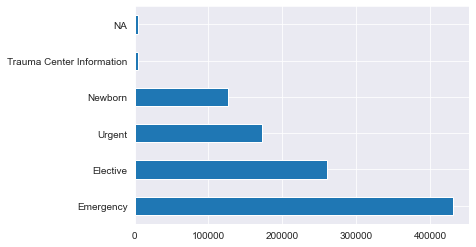

In [10]:
df.TYPE_OF_ADMISSION.value_counts().plot(kind="barh")

### 'SOURCE_OF_ADMISSION'

* Need to come back and split 5 and 6 for newborns (see doc)

In [11]:
df.SOURCE_OF_ADMISSION.value_counts(dropna=False)

1      602529
2      174032
5      131212
4       65285
6        8782
8        7591
D        4861
9        4457
`         762
NaN       171
0          10
3           5
7           1
Name: SOURCE_OF_ADMISSION, dtype: int64

In [12]:
mapping = {
    "1" : "Non-healthcare Facility",
    "2": "Clinical referral",
    "4": "Transfer from a hospital",
    "5": "Transfer from nursing facility",
    "6": "Transfer from another facility",
    "8": "Court/Law",
    "9": "NA",
    "0": "Transfer from another facility",
    "D": "Internal",
    "3": "NA",
    "7": "NA",
    "`": "NA",
    np.nan: "NA",
}

clean_cat("SOURCE_OF_ADMISSION", mapping)

### 'PAT_STATE'

In [13]:
df.PAT_STATE.value_counts(dropna=False)

TX     971963
ZZ       8520
NM       5772
AR       4571
OK       3476
FC       2653
LA       2140
NaN       256
XX        239
`         108
Name: PAT_STATE, dtype: int64

In [14]:
mapping = {
    "AR" : "Arkansas",
    "LA": "Louisiana",
    "NM": "New Mexico",
    "OK": "Oklahoma",
    "TX": "Texas",
    "ZZ": "Other states",
    "FC": "Foreign",
    "XX": "Foreign",
    "`": "NA",
    np.nan: "NA",
}

clean_cat("PAT_STATE", mapping)

### 'PAT_ZIP' - need to merge rare levels

In [15]:
df.PAT_ZIP.value_counts(dropna=False)

NaN      72042
88888     7745
78521     4044
`         3743
79936     3237
         ...  
324          1
182          1
021          1
601          1
076          1
Name: PAT_ZIP, Length: 1885, dtype: int64

### 'PAT_COUNTRY'

* too imbalanced - might make binary features for US, NaN, MX, OTHER

In [16]:
df.PAT_COUNTRY.value_counts(dropna=False)

US     990594
NaN      6585
MX       2026
SA        117
QA         61
KW         52
AE         44
CA         42
PE         21
VE         20
IN         18
HN         18
`          17
CN         14
EC         13
GT         10
NG          9
SV          6
CO          6
DE          5
GB          4
NO          3
EG          3
TR          2
RU          2
PA          1
IT          1
KY          1
DK          1
CR          1
AR          1
Name: PAT_COUNTRY, dtype: int64

### 'PAT_COUNTY'

* too many levels - need to merge

In [17]:
df.COUNTY.value_counts(dropna=False)

201    156638
113     93180
029     67060
439     65180
453     35182
        ...  
393        22
261        21
443        18
033        13
269         2
Name: COUNTY, Length: 254, dtype: int64

### 'PUBLIC_HEALTH_REGION'

In [18]:
df.PUBLIC_HEALTH_REGION.value_counts(dropna=False)

03     250838
06     231602
07     106116
08     100396
11      87188
04      46790
NaN     33483
05      33397
01      33004
10      31766
09      22981
02      22137
Name: PUBLIC_HEALTH_REGION, dtype: int64

In [19]:
df.PUBLIC_HEALTH_REGION.fillna("NA", inplace=True)

### 'SEX_CODE'

In [20]:
df.SEX_CODE.value_counts(dropna=False)

F      561244
M      367642
NaN     70626
U         186
Name: SEX_CODE, dtype: int64

In [21]:
mapping = {
    "F": "Female",
    "M": "Male",
    "U": "NA",
    np.nan: "NA",
}

clean_cat("SEX_CODE",mapping)

### 'RACE'

In [22]:
df.RACE.value_counts(dropna=False)

4      624277
5      216944
3      132390
2       19697
NaN      3644
1        2604
`         142
Name: RACE, dtype: int64

In [23]:
mapping = {
    "1": "American Indian",
    "2": "Asian",
    "3": "Black",
    "4": "White",
    "5": "Other",
    "`": "NA",
    np.nan: "NA",
}

clean_cat("RACE", mapping)

<AxesSubplot:>

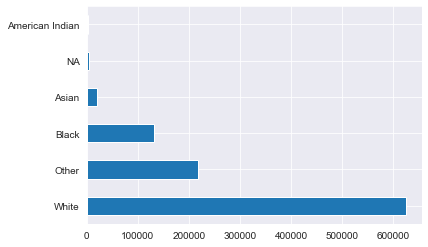

In [24]:
df.RACE.value_counts().plot(kind="barh")

### 'ETHNICITY'

In [25]:
df.ETHNICITY.value_counts(dropna=False)

2      702507
1      286098
NaN      7110
`        3983
Name: ETHNICITY, dtype: int64

In [26]:
mapping = {
    "1": "Hispanic Origin",
    "2": "Not of Hispanic",
    "`": "NA",
    np.nan: "NA",
}

clean_cat("ETHNICITY", mapping)

In [27]:
pd.crosstab(df.ETHNICITY, df.RACE)

RACE,American Indian,Asian,Black,NA,Other,White
ETHNICITY,,,,,,
Hispanic Origin,649,528,4046,301,159906,120668
NA,148,273,718,722,4446,4786
Not of Hispanic,1807,18896,127626,2763,52592,498823


In [34]:
print(df.shape)
df.isna().sum()

(999698, 195)


RECORD_ID                           0
DISCHARGE                           0
THCIC_ID                            0
PROVIDER_NAME                      62
TYPE_OF_ADMISSION                   0
                                ...  
OPERATING_PHYSICIAN_UNIF_ID    426037
ENCOUNTER_INDICATOR                 0
CERT_STATUS                         0
FILLER_SPACE                   999698
TARGET                              0
Length: 195, dtype: int64

In [31]:
df.to_pickle(f"{ROOT}/data/df_train_sample_00_of_1_clean.pkl")